In [1]:
%pip install einops
%pip install wandb

     |████████████████████████████████| 1.8MB 14.0MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 174kB 48.2MB/s 
     |████████████████████████████████| 133kB 50.0MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=f880bbcb0054703e7d29c04068d8a9e4cf8cfdb979f595e92bea91bdddf6a6b9
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=00dbb3e7dcba6bb93f120964d7f8311756d60c61af290239ace63f55fbcd842b
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
%cd drive/MyDrive/'Colab Notebooks'/tensorflow_workspace

/content/drive/MyDrive/Colab Notebooks/tensorflow_workspace


In [10]:
#g_MLP
config={
    "epochs": 64,
    "batch_size": 256,
    "lr" : 1e-6,
    "image_size" : 32,
    "channels" : 3,
    "num_classes" : 10,
    "hidden_dim" : 128,
    "patch_size" : 8,
    "depth" : 4,
    "d_ff" : 1024,
    "dataset" : 'CIFAR10',
    }

In [11]:
from model.MLP_Mixer_model import MLP_Mixer1_build
from model.gMLP_model import build_gMLP
from model.NesT_model import build_nesT

#modelの選択
#model = MLP_Mixer1_build(**config)
model = build_gMLP(**config)
#model = build_nesT(**config)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rearrange (Rearrange)        (None, 64, 48)            0         
_________________________________________________________________
dense (Dense)                (None, 64, 128)           6144      
_________________________________________________________________
g_mlp_block (gMLPBlock)      (None, 64, 128)           202048    
_________________________________________________________________
g_mlp_block_1 (gMLPBlock)    (None, 64, 128)           202048    
_________________________________________________________________
g_mlp_block_2 (gMLPBlock)    (None, 64, 128)           202048    
_________________________________________________________________
g_mlp_block_3 (gMLPBlock)    (None, 64, 128)           202048

In [12]:
import wandb
wandb.init(config=config, project="cifar10_MLP_Mixer", entity='NoguNogu',name='gMLP')

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
from myImageDataGenerator import get_dataset
from myImageDataGenerator import PatchImageDataGenerator

dataset = get_dataset(**config)
x_train, x_val, y_train, y_val = dataset.setting()

train_datagen = PatchImageDataGenerator(rotation_range=5,width_shift_range=0.1,height_shift_range=0.1, horizontal_flip=True)
train_generator = train_datagen.flow(x_train, y_train, batch_size=config['batch_size'])

170500096/170498071 [==============================] - 6s 0us/step


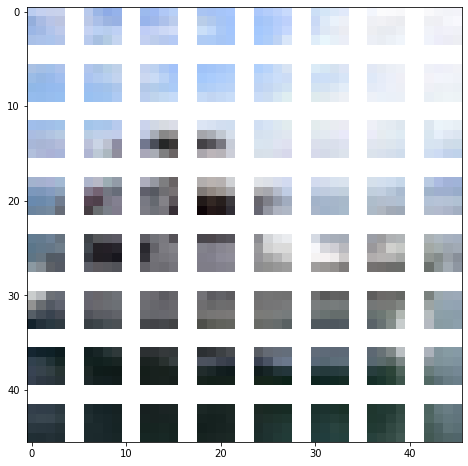

In [14]:
from utils.visualize import Visualize_patch, Visual_weight

Visualize_patch(x_train, **config)

In [15]:
from wandb.keras import WandbCallback
import tensorflow as tf

def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

N_train = x_train.shape[0]
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator,
                    validation_data=(x_val, y_val),
                    steps_per_epoch=N_train//config['batch_size'],
                    epochs= config['epochs'],
                    verbose=1,
                    callbacks=[callback,
                               WandbCallback()])

Epoch 1/64
175/175 [==============================] - 27s 125ms/step - loss: 1.9331 - accuracy: 0.3044 - val_loss: 1.5372 - val_accuracy: 0.4448


wandb: ERROR Can't save model, h5py returned error: Layer gMLPBlock has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/64
175/175 [==============================] - 21s 118ms/step - loss: 1.4641 - accuracy: 0.4716 - val_loss: 1.3209 - val_accuracy: 0.5256
Epoch 3/64
175/175 [==============================] - 20s 117ms/step - loss: 1.3224 - accuracy: 0.5264 - val_loss: 1.2854 - val_accuracy: 0.5396
Epoch 4/64
175/175 [==============================] - 21s 118ms/step - loss: 1.2280 - accuracy: 0.5611 - val_loss: 1.2120 - val_accuracy: 0.5602
Epoch 5/64
175/175 [==============================] - 21s 118ms/step - loss: 1.1633 - accuracy: 0.5856 - val_loss: 1.1842 - val_accuracy: 0.5720
Epoch 6/64
175/175 [==============================] - 21s 119ms/step - loss: 1.1102 - accuracy: 0.6088 - val_loss: 1.0920 - val_accuracy: 0.6012
Epoch 7/64
175/175 [==============================] - 21s 118ms/step - loss: 1.0603 - accuracy: 0.6256 - val_loss: 1.0404 - val_accuracy: 0.6222
Epoch 8/64
175/175 [==============================] - 21s 119ms/step - loss: 1.0109 - accuracy: 0.6404 - val_loss: 0.9985 - val_ac

In [17]:
from utils.visualize import Visualize_gMLP

#Layer Weightの取得
layer_num = 3

#Visual_gMLP(layer_num, model, **config)

In [ ]:
load_model = tf.keras.models.load_model("./save/gMLP_Train", 
                                        custom_objects = {"gMLPBlock": gMLPBlock})